# Sales EDA

By Eric Wilson

### Import Libraries and Data

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
sales = pd.read_csv('../input/retail-sales-forecasting/mock_kaggle.csv')
sales.head()

,data,venda,estoque,preco
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29


This data comes from a Brazil; we'll convert the columns from Portugese into English.

In [3]:
sales = sales.rename(columns={'data' : 'Date', 'venda' : 'Sales', 'estoque' : 'Stock', 'preco' : 'Price'})
print(sales.shape)
sales.head()

(937, 4)


,Date,Sales,Stock,Price
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29


### Data Cleaning

Let's make sure that there aren't any null values, or any unusable data.

In [4]:
sales.isnull().sum()

Date     0
Sales    0
Stock    0
Price    0
dtype: int64

Well, that makes it easy. Now, for data types.

In [5]:
sales.dtypes

Date      object
Sales      int64
Stock      int64
Price    float64
dtype: object

We need to convert Date to datetime, versus object. We'll also split the datetime into Day, Month, and Year catagories, to make more analysis options available (sales per year, stock per month, etc...). Finally, we'll add a "revenue" column, which will be sales multiplied by price, to see how much money was made per day.

In [6]:
sales['Date'] = pd.to_datetime(sales['Date'], format='%Y-%m-%d')
sales.dtypes

Date     datetime64[ns]
Sales             int64
Stock             int64
Price           float64
dtype: object

In [7]:
sales = sales.assign(Day = sales.Date.dt.day,
               Month = sales.Date.dt.month,
               Year = sales.Date.dt.year)
sales['Revenue'] = sales['Sales'] * sales['Price']
sales.dtypes

Date       datetime64[ns]
Sales               int64
Stock               int64
Price             float64
Day                 int64
Month               int64
Year                int64
Revenue           float64
dtype: object

Let's check if there's any leakage now the the data is a little more friendly. We'll see how many time each year shows up (since all variables are tied to the date sold, and there should be fewer years on file than months or days).

In [8]:
sales.Year.value_counts()

2015    365
2014    359
2016    213
Name: Year, dtype: int64

It looks like our data is missing about a week in 2014, perfect for 2015, and incomplete for 2016. Good to know.

### Data Exploration

First, let's see if there's any correlation between the variables.

In [9]:
sales.corr()

,Sales,Stock,Price,Day,Month,Year,Revenue
Sales,1.000000,0.153659,0.094779,-0.062452,-0.020992,0.264477,0.912127
Stock,0.153659,1.000000,-0.032604,0.022778,-0.364307,-0.153145,0.151113
Price,0.094779,-0.032604,1.000000,0.001580,-0.062187,0.618943,0.399306
Day,-0.062452,0.022778,0.001580,1.000000,0.007236,-0.001551,-0.059509
Month,-0.020992,-0.364307,-0.062187,0.007236,1.000000,-0.265074,-0.021615
Year,0.264477,-0.153145,0.618943,-0.001551,-0.265074,1.000000,0.474632
Revenue,0.912127,0.151113,0.399306,-0.059509,-0.021615,0.474632,1.000000


Based on the size of the data, I would say anything less than .1 is a minor correlation and likely to have some coincidence, rather than a strong meaning. Further, with the data from Dates having a correlation, I would say that's simply coincidence as well.

For Sales, there is some positive correlation between Year and Sales, and a little positive correlation between Sales and Stock. It seems that more stock leads to more sales, and sales have increased year over year.

For Stock, there is some negative correlation between Month and Stock, and a little negative correlation between Year and Stock. As the year goes on, stock seems to diminish, and each year sees less stock available than previous years. Could this hint at production issues, or a heavy stockpile to begin with?

For Price, the only correlation that really shows is between Price and Year. There is a slightly strong correlation between an increase in price as time goes by; perhaps, like a lesser amount of stock in later years, this has to do with supply and demand trying to find a new equilibrium? 

Revenue, which should not come as a surprise, is very highly correlated to sales - you can't make money if you don't sell product. There is a moderate correlation to price, as well, but price is far less important in determining revenue than the number of sales.

#### Changes in Variables by Date

Text(0.5, 1.0, 'Revenue')

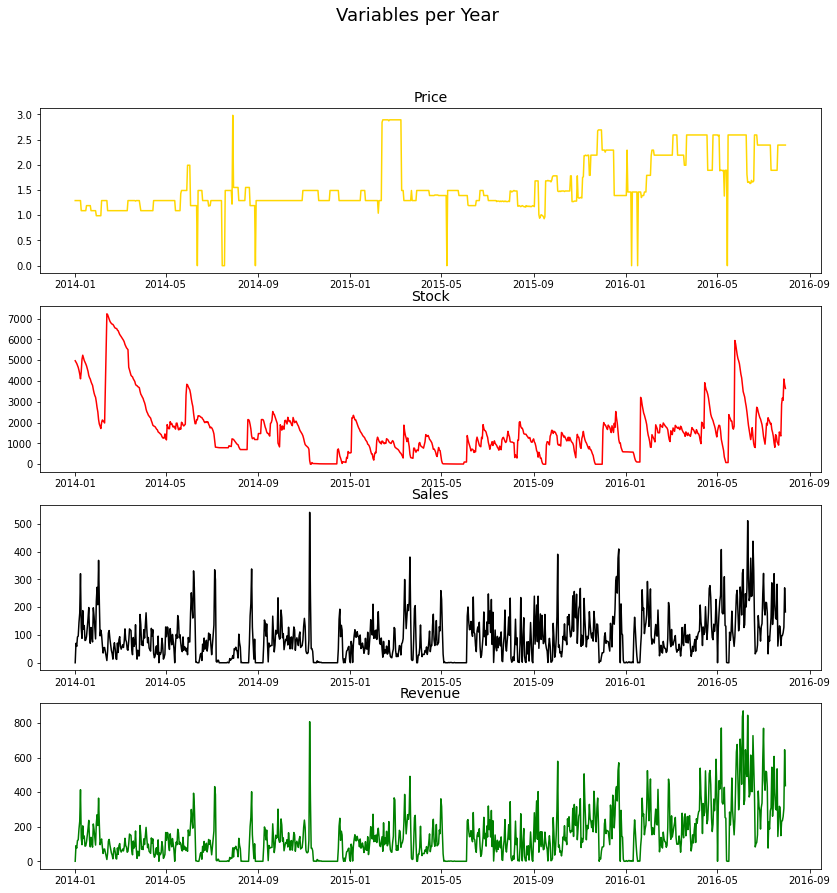

In [10]:
fig, axs = plt.subplots(4, figsize = [14, 14])
fig.suptitle('Variables per Year', fontsize = 18)
axs[0].plot(sales.Date, sales.Price, color = 'gold')
axs[0].set_title('Price', fontsize = 14)
axs[1].plot(sales.Date, sales.Stock, color = 'red')
axs[1].set_title('Stock', fontsize = 14)
axs[2].plot(sales.Date, sales.Sales, color = 'black')
axs[2].set_title('Sales', fontsize = 14)
axs[3].plot(sales.Date, sales.Revenue, color = 'green')
axs[3].set_title('Revenue', fontsize = 14)

Each of the variables shows a pretty strong amount of volatility. 

Price seems to be the most stable of all, with a minimal amount of sharp peaks and troughs, being better represented by plateaus. 

For stock, nothing seems extraordinary: stock climbs steeply as large shipments or orders are received, and then dwindles as sales are made.

As for sales, it is the most volatile of all variables. It will be worth looking into specific days of the week to see what days are the most popular.

#### Data by Days

Let's see what the averages of sales, stock, price, and revenue tend to look like based on day of the month. 

In [11]:
dsales = sales.groupby('Day').mean()
dsales = dsales[['Sales', 'Stock', 'Price', 'Revenue']]

Text(0.5, 1.0, 'Revenue')

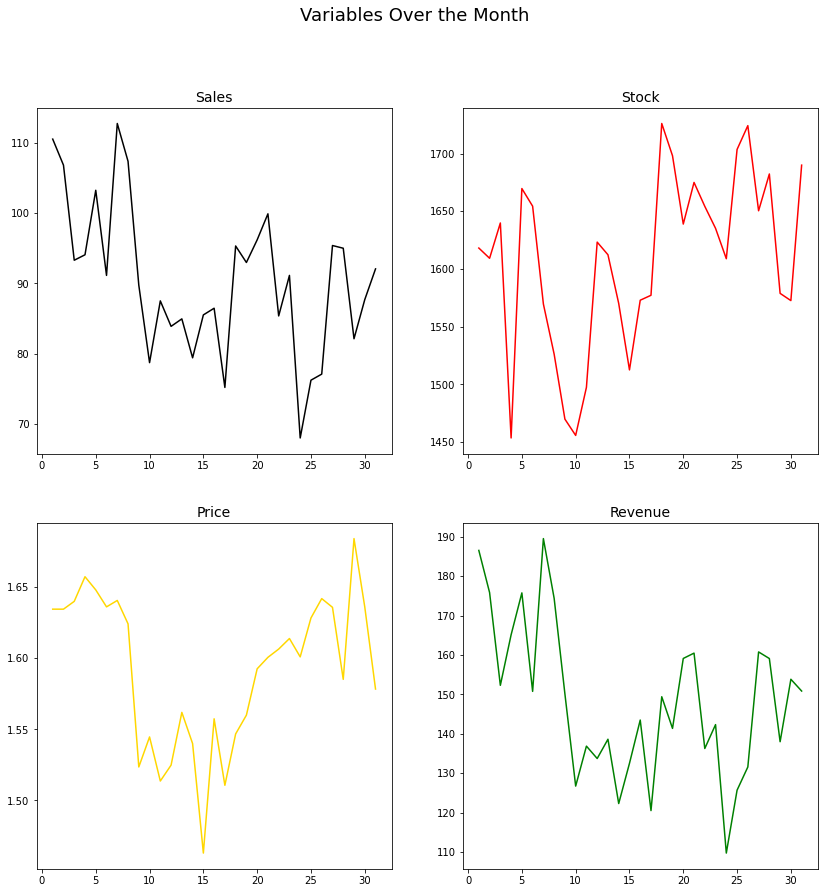

In [12]:
fig, axs = plt.subplots(2, 2 , figsize = [14, 14])
fig.suptitle('Variables Over the Month', fontsize = 18)
axs[0, 0].plot(dsales.index, dsales.Sales, color = 'black')
axs[0, 0].set_title('Sales', fontsize = 14)
axs[0, 1].plot(dsales.index, dsales.Stock, color = 'red')
axs[0, 1].set_title('Stock', fontsize = 14)
axs[1, 0].plot(dsales.index, dsales.Price, color = 'gold')
axs[1, 0].set_title('Price', fontsize = 14)
axs[1, 1].plot(dsales.index, dsales.Revenue, color = 'green')
axs[1, 1].set_title('Revenue', fontsize = 14)

Let's put all four variables on a graph to compare movements. First, we'll do a rough scaling by amplifying the values of price and sales, in order to ensure all variables have values on a similar scale.

In [13]:
dsm = dsales
dsm['Price'] = dsm['Price'] * 1000
dsm['Sales'] = dsm['Sales'] * 15
dsm['Revenue'] = dsm['Revenue'] * 10
dsm = dsm.reset_index()

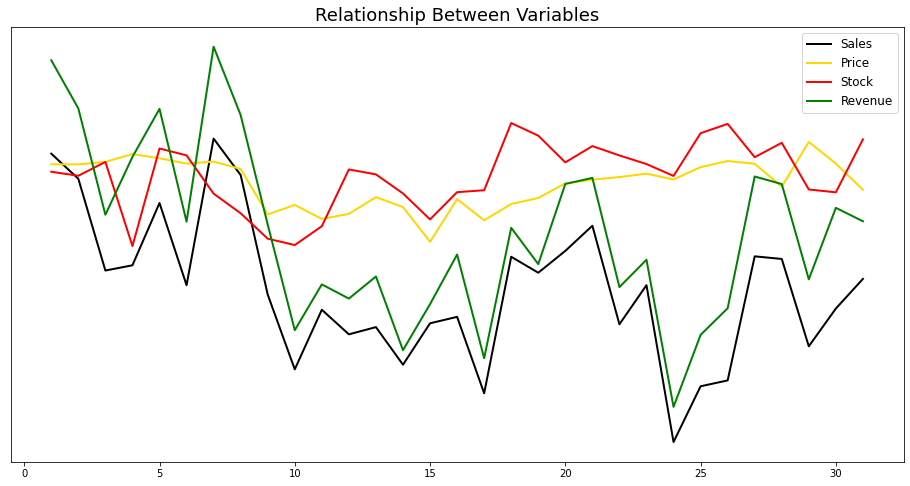

In [14]:
plt.figure(figsize=(16,8))
plt.title('Relationship Between Variables', fontsize = 18)
plt.plot('Day', 'Sales', data = dsm, color='black', linewidth=2, label = "Sales")
plt.plot('Day', 'Price', data = dsm, color='gold', linewidth=2, label = "Price")
plt.plot('Day', 'Stock', data = dsm, color='red', linewidth=2, label="Stock")
plt.plot('Day', 'Revenue', data = dsm, color='green', linewidth=2, label="Revenue")
plt.yticks([])
plt.legend(fontsize = 12)

It can be seen that sales (and, therefore, revenue) peak at the beginnings of the months, and have a minor uptick later in the months. 

Stock tends to get depleted towards the beginnings of the months, in two noticable waves, before slowly refilling throughout the rest of the month.

Price tends to be slightly higher at the beginnings and ends of the months with a slump towards the middle of the month.

#### Data by Month

Similarly now, let's take a look at what business looks like, on average, over the course of a year. It is worth noting that 2016 data is missing later months, so the last few months only take 2014 and 2015 into account. 

In [15]:
msales = sales.groupby('Month').mean()
msales = msales[['Sales', 'Stock', 'Price', 'Revenue']]

Text(0.5, 1.0, 'Revenue')

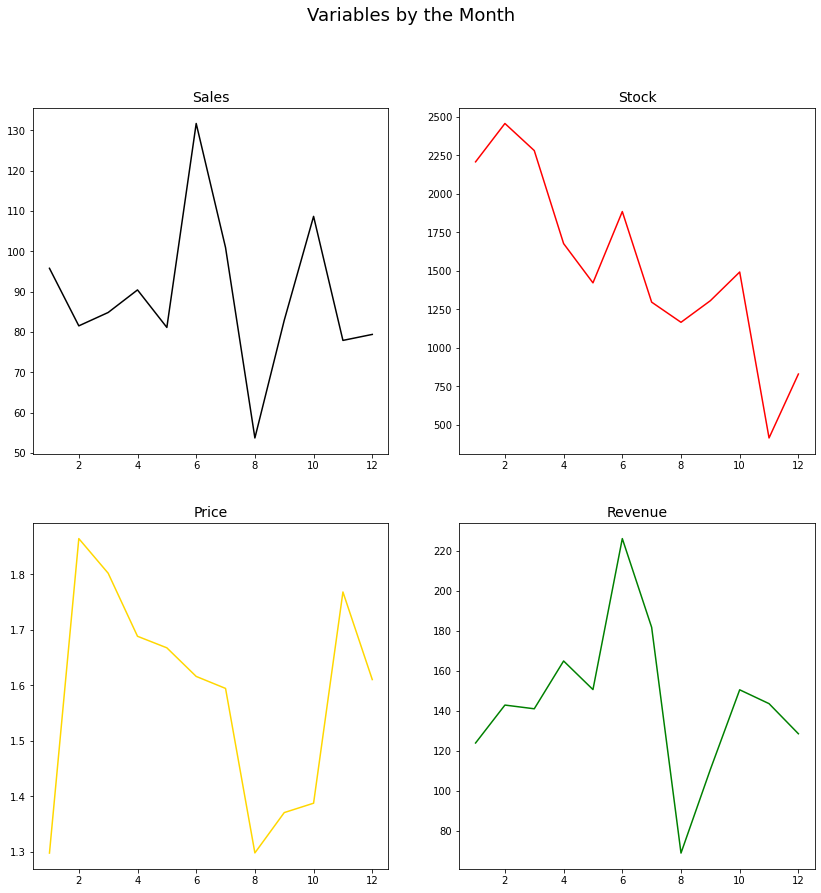

In [16]:
fig, axs = plt.subplots(2, 2 , figsize = [14, 14])
fig.suptitle('Variables by the Month', fontsize = 18)
axs[0, 0].plot(msales.index, msales.Sales, color = 'black')
axs[0, 0].set_title('Sales', fontsize = 14)
axs[0, 1].plot(msales.index, msales.Stock, color = 'red')
axs[0, 1].set_title('Stock', fontsize = 14)
axs[1, 0].plot(msales.index, msales.Price, color = 'gold')
axs[1, 0].set_title('Price', fontsize = 14)
axs[1, 1].plot(msales.index, msales.Revenue, color = 'green')
axs[1, 1].set_title('Revenue', fontsize = 14)

Sales peak in June and hit their bottom in August, both during the winter months (for the Southern Hemisphere) - could weather have something to do with supply and demand?

Stock, similar to data over the course of a month, begins with a much larger reserve and dwindles as the year continues. 

Price has two noticable peaks, at the start and end of the year - they may be much closer on a linear timeline than by the breakdown shown here.

Revenue sees a more general climb towards its' peak than sales, without as much of a second peak late in the year, due to the lower value of price.

#### Top 5 Most Common Price Values

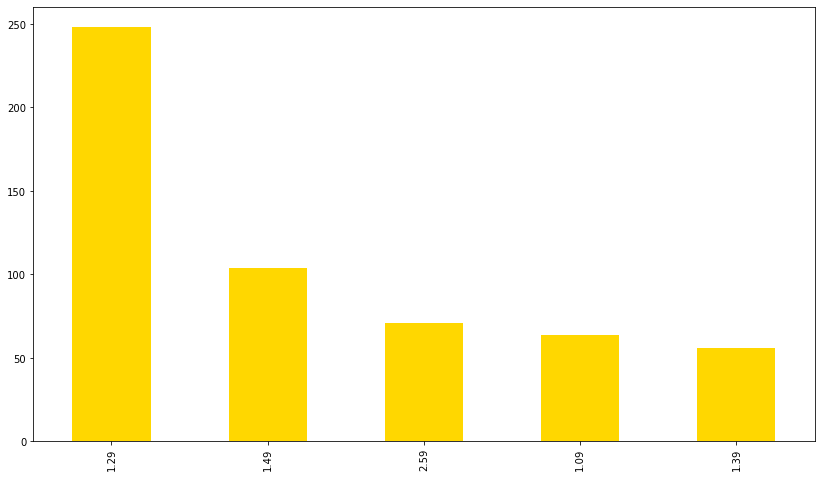

In [17]:
### Only showing the 5 most common prices
sales.Price.value_counts().head().plot(kind='bar', color = 'gold', figsize = (14, 8))

It would be safe to assume that 1.29 monetary units (specific monetary units were not mentioned in the data) is the market equilibrium, being represented nearly 2.5x more often than the next closest price. 

### Conclusion

Based on the data, the 7th of June should be expected to bring in the most money of the year, whereas the 24th of August should be expected to earn the least amount of money of the year.

Stock should hit its' lowest points of the year in early November, while climbing to its' highest points in the middle through late February.

Price should trough around the 15th of August, hitting its' lowest point, while peaking around the start and end of February.